In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor
import pandas as pd

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader

import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt 
writer = SummaryWriter('mnist_experiment_1')

<IPython.core.display.Javascript object>

In [5]:
bs = 16
# MNIST Dataset
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


<IPython.core.display.Javascript object>

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list, z_dim):
        super(VAE, self).__init__()
        
        self.z_dim = z_dim
        
        self.encoder_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim[0])])
        self.decoder_layers = nn.ModuleList([nn.Linear(hidden_dim[0], input_dim)])
                
        if len(hidden_dim)>1:
            for i in range(len(hidden_dim)-1):
                self.encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                self.decoder_layers.insert(0, nn.Linear(hidden_dim[i+1], hidden_dim[i]))
                
        self.encoder_layers.append(nn.Linear(hidden_dim[-1], 2 * z_dim))
        self.decoder_layers.insert(0, nn.Linear(z_dim, hidden_dim[-1]))

        
    def encoder(self, x):
        for idx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            if idx < len(self.encoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                x = F.relu(x)
        return x[...,:self.z_dim], x[...,self.z_dim:] # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        # std = torch.abs(log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        for idx, layer in enumerate(self.decoder_layers):
            z = layer(z)
            if idx < len(self.decoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                z = F.relu(z)
        return torch.sigmoid(z) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        
    #    z = self.sampling(mu, log_var)
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(torch.exp(0.5*log_var)))
        z = latent.rsample()
           
    #    return self.decoder(z), mu, log_var
        return self.decoder(z), latent

    @staticmethod
    def loss_function(recon_x, x, mu, log_var):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD
    
    @staticmethod
    def loss_function_dist(recon_x, x, latent):
        prior = MultivariateNormal(loc = torch.zeros(latent.mean.shape[1]),
                                   scale_tril=torch.eye(latent.mean.shape[1]))
        
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = torch.sum(kl_divergence(latent, prior))
        return BCE + KLD

<IPython.core.display.Javascript object>

In [7]:
 def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, (data, _) in enumerate(train_loader):
        
        # Every data instance 
        data = data.to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        recon_batch, latent = vae(data)

        # Compute the loss and its gradients
        loss = VAE.loss_function_dist(recon_batch, data, latent)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

<IPython.core.display.Javascript object>

In [8]:
# build model

vae = VAE(input_dim=784, hidden_dim=[512, 256], z_dim=16)
# if torch.backends.mps.is_available():
#     DEVICE = 'mps'
# else:
#train_loader = torch.utils.data.DataLoader(dataset=torch.Tensor(torch.randn(30, 5000)), batch_size=100, shuffle=True)

DEVICE = 'cpu'
    
vae.to(DEVICE)

optimizer = optim.Adam(vae.parameters())


# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/tcga_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 20

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    vae.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    vae.train(False)

    running_vloss = 0.0
    for i, (vdata, _) in enumerate(validation_loader):
        vinputs = vdata
        voutputs, latent = vae(vinputs)
        
        vloss = VAE.loss_function_dist(voutputs, vinputs, latent)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        #torch.save(vae.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2665.491913330078
  batch 2000 loss: 2117.8309284667966
  batch 3000 loss: 1998.014379638672
LOSS train 1998.014379638672 valid 1899.58642578125
EPOCH 2:
  batch 1000 loss: 1896.6456954345704
  batch 2000 loss: 1862.0338298339843
  batch 3000 loss: 1840.5867249755859
LOSS train 1840.5867249755859 valid 1807.5081787109375
EPOCH 3:
  batch 1000 loss: 1818.4597224121094
  batch 2000 loss: 1792.374907836914
  batch 3000 loss: 1778.7145704345703
LOSS train 1778.7145704345703 valid 1764.85498046875
EPOCH 4:
  batch 1000 loss: 1759.0020806884766
  batch 2000 loss: 1751.0394204101563
  batch 3000 loss: 1746.8103354492187
LOSS train 1746.8103354492187 valid 1734.64404296875
EPOCH 5:
  batch 1000 loss: 1733.5542026367189
  batch 2000 loss: 1726.115698852539
  batch 3000 loss: 1728.1253311767578
LOSS train 1728.1253311767578 valid 1725.376220703125
EPOCH 6:
  batch 1000 loss: 1713.8523585205078
  batch 2000 loss: 1715.4469758300781
  batch 3000 loss: 1713.5805224609376

<IPython.core.display.Javascript object>

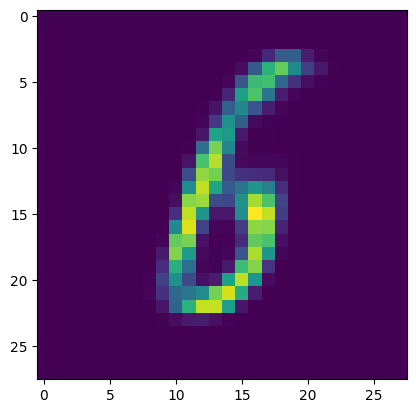

<IPython.core.display.Javascript object>

In [9]:
# %%
import matplotlib.pyplot as plt
z = torch.randn(64, 16)
sample = vae.decoder(z).detach()
plt.imshow(sample.view(64, 1, 28, 28)[2].permute(1, 2, 0)  )


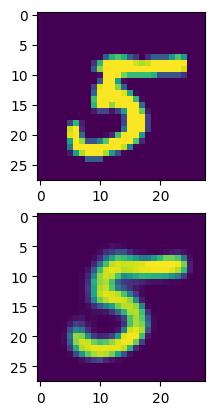

<IPython.core.display.Javascript object>

In [10]:
# %%
idx = 4
ax = plt.subplot(2,1,1)
plt.imshow(vdata[idx,:].permute(1, 2, 0)  )
ax = plt.subplot(2,1,2)
plt.imshow(voutputs.detach().view(16, 1, 28, 28)[idx].permute(1, 2, 0))

# %%

Permute some pixals of an image

In [11]:

# Get the dimensions of the image tensor
C, H, W = vdata[15].shape

# Define the number of pixels to permute and randomly select pixel indices
num_pixels_to_permute = int(H*W*0.4) # permute only 50% of pixels
perm_indices = torch.randperm(H*W)[:num_pixels_to_permute]

# Define the subset of pixels to be permuted
subset_indices = torch.randperm(num_pixels_to_permute)[:num_pixels_to_permute//2]

# Create a tensor to hold the permutation order for the selected pixels
perm_order = torch.randperm(num_pixels_to_permute//2)

# Flatten the image tensor and permute the selected pixels
flat_img_tensor = vdata[15].detach().clone().view(C, H*W)
flat_img_tensor[:, perm_indices[subset_indices]] = flat_img_tensor[:, perm_indices[subset_indices[perm_order]]]

# Reshape the permuted tensor back to its original shape
permuted_img_tensor = flat_img_tensor.view(C, H, W)



<IPython.core.display.Javascript object>

In [12]:
recon_test_orig, latent_test_orig = vae(vdata[15])

<IPython.core.display.Javascript object>

In [13]:
recon_test, latent_test = vae(permuted_img_tensor)

<IPython.core.display.Javascript object>

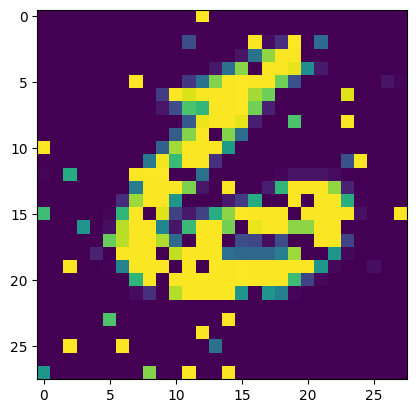

<IPython.core.display.Javascript object>

In [14]:
plt.imshow(permuted_img_tensor.detach().view(1, 28, 28).permute(1, 2, 0))

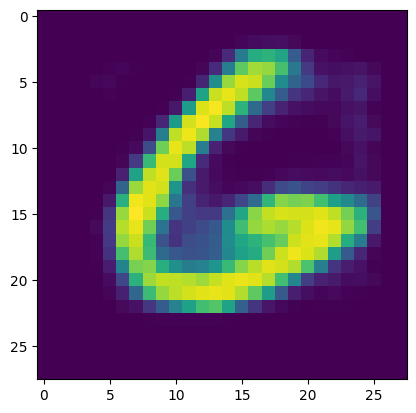

<IPython.core.display.Javascript object>

In [15]:
plt.imshow(recon_test.detach().view(1, 28, 28).permute(1, 2, 0))

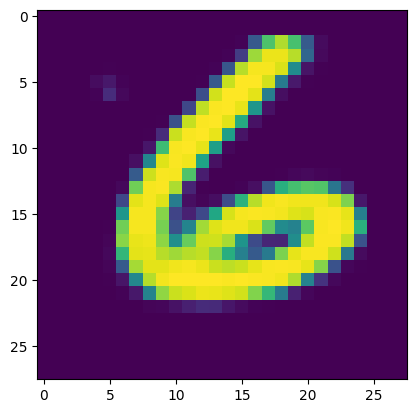

<IPython.core.display.Javascript object>

In [16]:
plt.imshow(recon_test_orig.detach().view(1, 28, 28).permute(1, 2, 0))

In [115]:
import warnings
warnings.filterwarnings("ignore")
# Define the number of columns
n = 784

# Create an empty Pandas dataframe
reconstructed_df = pd.DataFrame()
original_df = pd.DataFrame()

# Add n columns to the dataframe
for i in range(n):
    reconstructed_df[f'Column {i+1}'] = []
    original_df[f'Column {i+1}'] = []

<IPython.core.display.Javascript object>

In [157]:
BCE_loss = []
KLD_loss = []
MSE_loss = []

for (vdata, _) in validation_loader:
    
    for i in vdata:
        reconstructed_df = reconstructed_df.append(
            pd.DataFrame(vae.forward(i)[0].detach().numpy(), 
                         columns=reconstructed_df.columns), ignore_index=True)

        original_df = original_df.append(pd.DataFrame(i.view(-1,784).numpy(), 
                                                      columns=original_df.columns), ignore_index=True)
        
        BCE_loss.append(F.binary_cross_entropy(vae.forward(i)[0], i.view(-1,784), reduction='sum').cpu().detach().item())
        MSE_loss.append(F.mse_loss(vae.forward(i)[0], i.view(-1,784), reduction='sum').cpu().detach().item())
        
        prior = MultivariateNormal(loc = torch.zeros(vae.forward(i)[1].mean.shape[1]),
                                   scale_tril=torch.eye(vae.forward(i)[1].mean.shape[1]))
        KLD_loss.append(torch.sum(kl_divergence(vae.forward(i)[1], prior)).item())
        


<IPython.core.display.Javascript object>

In [158]:
reconstruction_fidelity = reconstructed_df - original_df

<IPython.core.display.Javascript object>

In [159]:
mnist_mean = reconstruction_fidelity.mean(axis=0)

<IPython.core.display.Javascript object>

In [160]:
mnist_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(reconstructed_df.shape[0])

<IPython.core.display.Javascript object>

In [161]:
summary = pd.DataFrame([mnist_mean, mnist_abssum], index=['mean', 'abs(sum)']).T

<IPython.core.display.Javascript object>

In [162]:
summary.sort_values(by='abs(sum)', ascending=False).head()

,mean,abs(sum)
Column 214,0.023259,0.152711
Column 213,0.006276,0.152560
Column 215,0.020499,0.150992
Column 241,-0.010663,0.149478
Column 212,-0.003811,0.146984


<IPython.core.display.Javascript object>

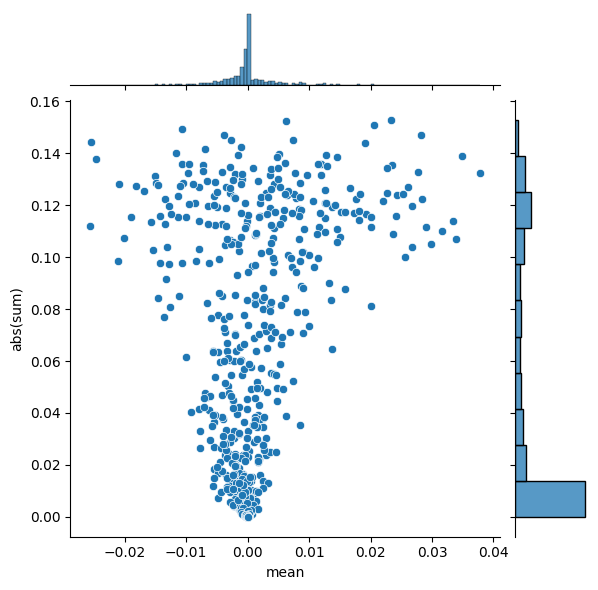

<IPython.core.display.Javascript object>

In [163]:
sns.jointplot(x = 'mean', y = 'abs(sum)',
              kind = "scatter", data = summary)
plt.savefig('results/no_permute.png')

In [164]:
n = 784

# Create an empty Pandas dataframe
reconstructed_permuted_30_df = pd.DataFrame()
reconstructed_permuted_50_df = pd.DataFrame()
reconstructed_permuted_90_df = pd.DataFrame()

# Add n columns to the dataframe
for i in range(n):
    reconstructed_permuted_30_df[f'Column {i+1}'] = []
    reconstructed_permuted_50_df[f'Column {i+1}'] = []
    reconstructed_permuted_90_df[f'Column {i+1}'] = []

<IPython.core.display.Javascript object>

In [165]:
# Create a clone of the original DataLoader object
validation_loader_30_permute = DataLoader(validation_loader.dataset, 
                                          batch_size=validation_loader.batch_size)
validation_loader_50_permute = DataLoader(validation_loader.dataset, 
                                          batch_size=validation_loader.batch_size)
validation_loader_90_permute = DataLoader(validation_loader.dataset, 
                                          batch_size=validation_loader.batch_size)

<IPython.core.display.Javascript object>

In [166]:
BCE_loss_30_permute = []
KLD_loss_30_permute = []
MSE_loss_30_permute = []

for (vdata, _) in validation_loader_30_permute:
    
    for i in vdata:
    
        # Get the dimensions of the image tensor
        C, H, W = i.shape

        # Define the number of pixels to permute and randomly select pixel indices
        num_pixels_to_permute = int(H*W*0.3) # permute only 50% of pixels
        perm_indices = torch.randperm(H*W)[:num_pixels_to_permute]

        # Define the subset of pixels to be permuted
        subset_indices = torch.randperm(num_pixels_to_permute)[:num_pixels_to_permute//2]

        # Create a tensor to hold the permutation order for the selected pixels
        perm_order = torch.randperm(num_pixels_to_permute//2)

        # Flatten the image tensor and permute the selected pixels
        flat_img_tensor = i.detach().clone().view(C, H*W)
        flat_img_tensor[:, perm_indices[subset_indices]] = flat_img_tensor[:, perm_indices[subset_indices[perm_order]]]

        # Reshape the permuted tensor back to its original shape
        permuted_img_tensor = flat_img_tensor.view(C, H, W)


        reconstructed_permuted_30_df = reconstructed_permuted_30_df.append(
            pd.DataFrame(vae.forward(permuted_img_tensor)[0].detach().numpy(), 
                         columns=reconstructed_permuted_30_df.columns), ignore_index=True)
        
        BCE_loss_30_permute.append(F.binary_cross_entropy(vae.forward(permuted_img_tensor)[0], 
                                                          i.view(-1,784), reduction='sum').cpu().detach().item())
        MSE_loss_30_permute.append(F.mse_loss(vae.forward(permuted_img_tensor)[0], 
                                              i.view(-1,784), reduction='sum').cpu().detach().item())
        
        prior = MultivariateNormal(loc = torch.zeros(vae.forward(permuted_img_tensor)[1].mean.shape[1]),
                                   scale_tril=torch.eye(vae.forward(permuted_img_tensor)[1].mean.shape[1]))
        KLD_loss_30_permute.append(torch.sum(kl_divergence(vae.forward(permuted_img_tensor)[1], prior)).item())
        

<IPython.core.display.Javascript object>

In [167]:
BCE_loss_50_permute = []
KLD_loss_50_permute = []
MSE_loss_50_permute = []

for (vdata, _) in validation_loader_50_permute:
    
    for i in vdata:
    
        # Get the dimensions of the image tensor
        C, H, W = i.shape

        # Define the number of pixels to permute and randomly select pixel indices
        num_pixels_to_permute = int(H*W*0.5) # permute only 50% of pixels
        perm_indices = torch.randperm(H*W)[:num_pixels_to_permute]

        # Define the subset of pixels to be permuted
        subset_indices = torch.randperm(num_pixels_to_permute)[:num_pixels_to_permute//2]

        # Create a tensor to hold the permutation order for the selected pixels
        perm_order = torch.randperm(num_pixels_to_permute//2)

        # Flatten the image tensor and permute the selected pixels
        flat_img_tensor = i.detach().clone().view(C, H*W)
        flat_img_tensor[:, perm_indices[subset_indices]] = flat_img_tensor[:, perm_indices[subset_indices[perm_order]]]

        # Reshape the permuted tensor back to its original shape
        permuted_img_tensor = flat_img_tensor.view(C, H, W)


        reconstructed_permuted_50_df = reconstructed_permuted_50_df.append(
            pd.DataFrame(vae.forward(permuted_img_tensor)[0].detach().numpy(), 
                         columns=reconstructed_permuted_50_df.columns), ignore_index=True)
        
        BCE_loss_50_permute.append(F.binary_cross_entropy(vae.forward(permuted_img_tensor)[0], 
                                                          i.view(-1,784), reduction='sum').cpu().detach().item())
        MSE_loss_50_permute.append(F.mse_loss(vae.forward(permuted_img_tensor)[0], 
                                              i.view(-1,784), reduction='sum').cpu().detach().item())
        
        prior = MultivariateNormal(loc = torch.zeros(vae.forward(permuted_img_tensor)[1].mean.shape[1]),
                                   scale_tril=torch.eye(vae.forward(permuted_img_tensor)[1].mean.shape[1]))
        KLD_loss_50_permute.append(torch.sum(kl_divergence(vae.forward(permuted_img_tensor)[1], prior)).item())
        

<IPython.core.display.Javascript object>

In [168]:
BCE_loss_90_permute = []
KLD_loss_90_permute = []
MSE_loss_90_permute = []
for (vdata, _) in validation_loader_90_permute:
    
    for i in vdata:
    
        # Get the dimensions of the image tensor
        C, H, W = i.shape

        # Define the number of pixels to permute and randomly select pixel indices
        num_pixels_to_permute = int(H*W*0.8) # permute only 50% of pixels
        perm_indices = torch.randperm(H*W)[:num_pixels_to_permute]

        # Define the subset of pixels to be permuted
        subset_indices = torch.randperm(num_pixels_to_permute)[:num_pixels_to_permute//2]

        # Create a tensor to hold the permutation order for the selected pixels
        perm_order = torch.randperm(num_pixels_to_permute//2)

        # Flatten the image tensor and permute the selected pixels
        flat_img_tensor = i.detach().clone().view(C, H*W)
        flat_img_tensor[:, perm_indices[subset_indices]] = flat_img_tensor[:, perm_indices[subset_indices[perm_order]]]

        # Reshape the permuted tensor back to its original shape
        permuted_img_tensor = flat_img_tensor.view(C, H, W)


        reconstructed_permuted_90_df = reconstructed_permuted_90_df.append(
            pd.DataFrame(vae.forward(permuted_img_tensor)[0].detach().numpy(), 
                         columns=reconstructed_permuted_90_df.columns), ignore_index=True)
        
        BCE_loss_90_permute.append(F.binary_cross_entropy(vae.forward(permuted_img_tensor)[0], 
                                                          i.view(-1,784), reduction='sum').cpu().detach().item())
        MSE_loss_90_permute.append(F.mse_loss(vae.forward(permuted_img_tensor)[0], 
                                              i.view(-1,784), reduction='sum').cpu().detach().item())
        
        prior = MultivariateNormal(loc = torch.zeros(vae.forward(permuted_img_tensor)[1].mean.shape[1]),
                                   scale_tril=torch.eye(vae.forward(permuted_img_tensor)[1].mean.shape[1]))
        KLD_loss_90_permute.append(torch.sum(kl_divergence(vae.forward(permuted_img_tensor)[1], prior)).item())
        

<IPython.core.display.Javascript object>

In [169]:
reconstruction_fidelity_30 = reconstructed_permuted_30_df - original_df
reconstruction_fidelity_50 = reconstructed_permuted_50_df - original_df
reconstruction_fidelity_90 = reconstructed_permuted_90_df - original_df

<IPython.core.display.Javascript object>

In [170]:
mnist_mean_30 = reconstruction_fidelity_30.mean(axis=0)
mnist_mean_50 = reconstruction_fidelity_50.mean(axis=0)
mnist_mean_90 = reconstruction_fidelity_90.mean(axis=0)

<IPython.core.display.Javascript object>

In [171]:
mnist_abssum_30 = reconstruction_fidelity_30.abs().sum(axis=0).divide(reconstructed_permuted_30_df.shape[0])
mnist_abssum_50 = reconstruction_fidelity_50.abs().sum(axis=0).divide(reconstructed_permuted_50_df.shape[0])
mnist_abssum_90 = reconstruction_fidelity_90.abs().sum(axis=0).divide(reconstructed_permuted_90_df.shape[0])

<IPython.core.display.Javascript object>

In [172]:
summary_30 = pd.DataFrame([mnist_mean_30, mnist_abssum_30], index=['mean', 'abs(sum)']).T
summary_50 = pd.DataFrame([mnist_mean_50, mnist_abssum_50], index=['mean', 'abs(sum)']).T
summary_90 = pd.DataFrame([mnist_mean_90, mnist_abssum_90], index=['mean', 'abs(sum)']).T

<IPython.core.display.Javascript object>

In [173]:
summary_30.sort_values(by='abs(sum)', ascending=False).head()

,mean,abs(sum)
Column 213,-0.071543,0.210777
Column 214,-0.065609,0.208677
Column 212,-0.068290,0.207022
Column 434,-0.035909,0.204502
Column 461,-0.007063,0.203576


<IPython.core.display.Javascript object>

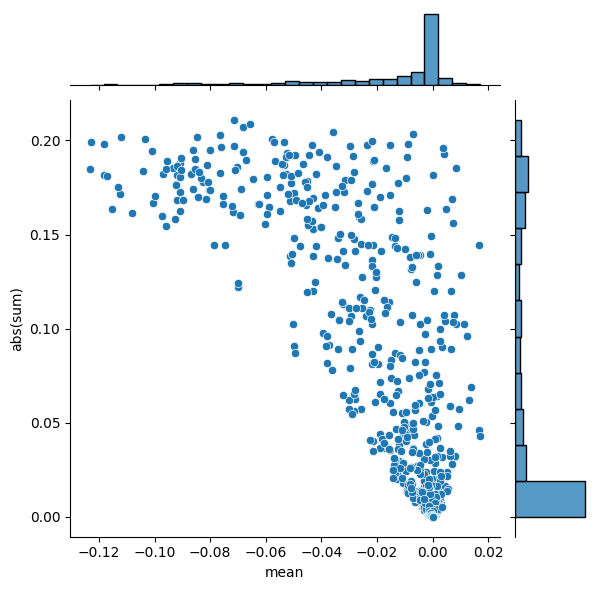

<IPython.core.display.Javascript object>

In [174]:
sns.jointplot(x = 'mean', y = 'abs(sum)',
              kind = "scatter", data = summary_30)
plt.savefig('results/30_percent_permute.png')

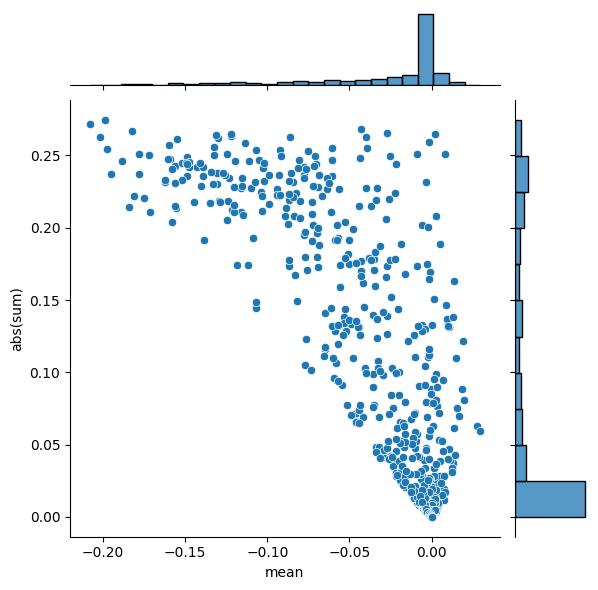

<IPython.core.display.Javascript object>

In [175]:
sns.jointplot(x = 'mean', y = 'abs(sum)',
              kind = "scatter", data = summary_50)
plt.savefig('results/50_percent_permute.png')

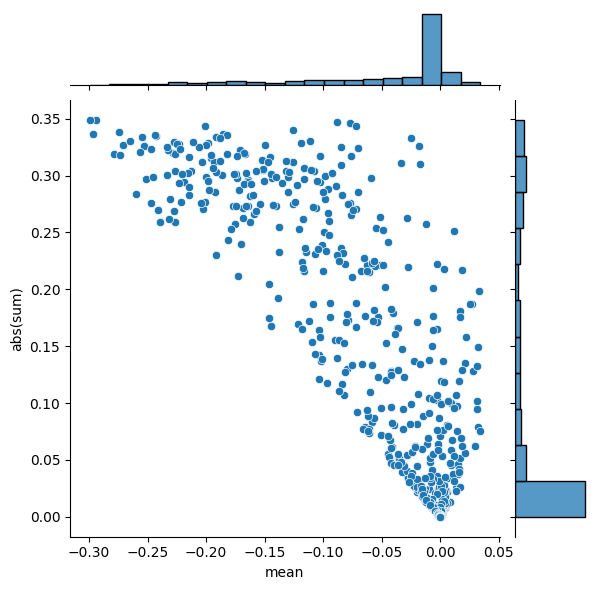

<IPython.core.display.Javascript object>

In [176]:
sns.jointplot(x = 'mean', y = 'abs(sum)',
              kind = "scatter", data = summary_90)
plt.savefig('results/90_percent_permute.png')

plots

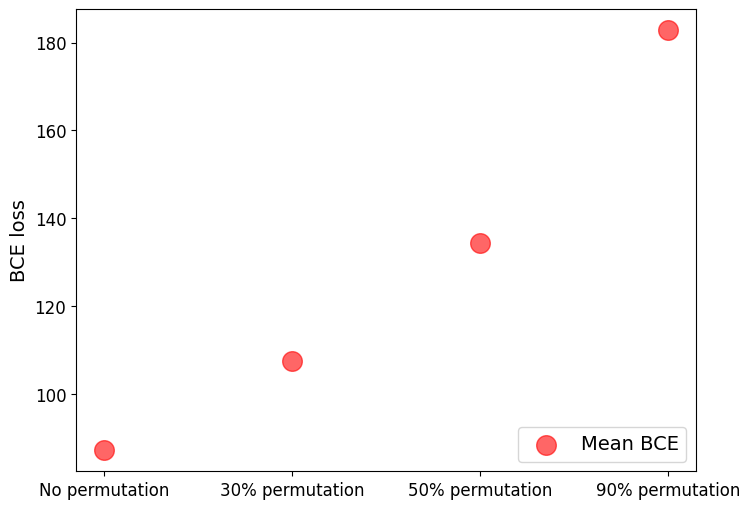

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

In [192]:
## compare the performance here
plt.figure(figsize=(8,6))

plt.scatter([0], [np.mean(BCE_loss)], c='r', s=200, alpha=.6, label="Mean BCE")
plt.scatter([1], [np.mean(BCE_loss_30_permute)], c='r', s=200, alpha=.6)
plt.scatter([2], [np.mean(BCE_loss_50_permute)], c='r', s=200, alpha=.6)
plt.scatter([3], [np.mean(BCE_loss_90_permute)], c='r', s=200, alpha=.6)

plt.legend(fontsize=14, loc=4)

plt.yticks(fontsize=12)
plt.xticks([0,1,2,3], ['No permutation', '30% permutation', '50% permutation', '90% permutation'], fontsize=12)

plt.ylabel("BCE loss", fontsize=14)
plt.show()
plt.savefig('results/BCE_loss.png')

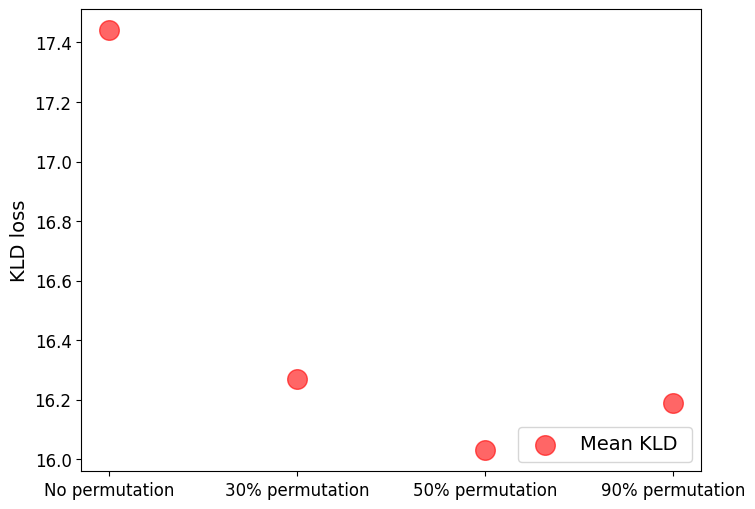

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

In [193]:
## compare the performance here
plt.figure(figsize=(8,6))

plt.scatter([0], [np.mean(KLD_loss)], c='r', s=200, alpha=.6, label="Mean KLD ")
plt.scatter([1], [np.mean(KLD_loss_30_permute)], c='r', s=200, alpha=.6)
plt.scatter([2], [np.mean(KLD_loss_50_permute)], c='r', s=200, alpha=.6)
plt.scatter([3], [np.mean(KLD_loss_90_permute)], c='r', s=200, alpha=.6)

plt.legend(fontsize=14, loc=4)

plt.yticks(fontsize=12)
plt.xticks([0,1,2,3], ['No permutation', '30% permutation', '50% permutation', '90% permutation'], fontsize=12)

plt.ylabel("KLD loss", fontsize=14)
plt.show()
plt.savefig('results/KLD_loss.png')

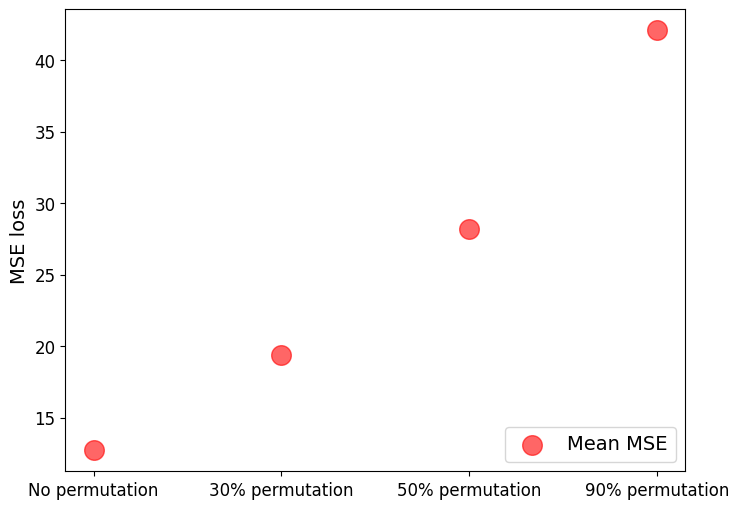

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

In [194]:
## compare the performance here
plt.figure(figsize=(8,6))

plt.scatter([0], [np.mean(MSE_loss)], c='r', s=200, alpha=.6, label="Mean MSE")
plt.scatter([1], [np.mean(MSE_loss_30_permute)], c='r', s=200, alpha=.6)
plt.scatter([2], [np.mean(MSE_loss_50_permute)], c='r', s=200, alpha=.6)
plt.scatter([3], [np.mean(MSE_loss_90_permute)], c='r', s=200, alpha=.6)

plt.legend(fontsize=14, loc=4)

plt.yticks(fontsize=12)
plt.xticks([0,1,2,3], ['No permutation', '30% permutation', '50% permutation', '90% permutation'], fontsize=12)

plt.ylabel("MSE loss", fontsize=14)
plt.show()
plt.savefig('results/MSE_loss.png')